In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm


In [2]:
class ESC50Dataset(Dataset):
    def __init__(self, csv_path, audio_dir, split="train", sr=16000):
        self.meta = pd.read_csv(csv_path)
        self.audio_dir = audio_dir
        self.sr = sr
        self.target_length = sr * 5  # 5 seconds

        if split == "train":
            self.meta = self.meta[self.meta["fold"] <= 3]
        elif split == "val":
            self.meta = self.meta[self.meta["fold"] == 4]
        else:
            self.meta = self.meta[self.meta["fold"] == 5]

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
        ])

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        path = os.path.join(self.audio_dir, row["filename"])

        y, _ = librosa.load(path, sr=self.sr)
        if len(y) < self.target_length:
            y = np.pad(y, (0, self.target_length - len(y)))
        else:
            y = y[:self.target_length]

        mel = librosa.feature.melspectrogram(        # 🔑 FIXED TEMPORAL RESOLUTION (10 ms hop)

            y=y,
            sr=self.sr,
            n_fft=400,
            hop_length=160,   # 10 ms
            n_mels=128
        )
        mel = librosa.power_to_db(mel)

        mel = torch.tensor(mel).float()     # [F, T]
        mel = mel.unsqueeze(0)              # [1, F, T]
        mel = mel.repeat(3, 1, 1)            # [3, F, T]
        mel = self.transform(mel)            # [3, 224, 224]

        return mel, int(row["target"])


In [3]:
train_ds = ESC50Dataset(
    csv_path="ESC-50-master/meta/esc50.csv",
    audio_dir="ESC-50-master/audio",
    split="train"
)

val_ds = ESC50Dataset(
    csv_path="ESC-50-master/meta/esc50.csv",
    audio_dir="ESC-50-master/audio",
    split="val"
)

test_ds = ESC50Dataset(
    csv_path="ESC-50-master/meta/esc50.csv",
    audio_dir="ESC-50-master/audio",
    split="test"
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=4)

print("Train:", len(train_ds))
print("Val  :", len(val_ds))
print("Test :", len(test_ds))


Train: 1200
Val  : 400
Test : 400


In [4]:
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

class ESC50EfficientNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = EfficientNet.from_pretrained("efficientnet-b2")

        for param in self.base.parameters():
            param.requires_grad = True

        in_features = self.base._fc.in_features
        self.base._fc = nn.Linear(in_features, 50)

    def forward(self, x):
        return self.base(x)



In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ESC50EfficientNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2.5e-4)

Loaded pretrained weights for efficientnet-b2


In [6]:
def train_epoch(loader):
    model.train()
    total_loss, correct = 0, 0

    for x, y in tqdm(loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()

    acc = correct / len(loader.dataset)
    return total_loss / len(loader), acc


def eval_epoch(loader):
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            total_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()

    acc = correct / len(loader.dataset)
    return total_loss / len(loader), acc


In [ ]:
import matplotlib.pyplot as plt

epochs = 80  # baseline dulu, jangan kebanyakan

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(train_loader)
    val_loss, val_acc = eval_epoch(val_loader)

    # Simpan history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f" Train Loss {train_loss:.4f} | Acc {train_acc:.4f}")
    print(f" Val   Loss {val_loss:.4f} | Acc {val_acc:.4f}")

# ===========================
# Plot Loss
# ===========================
plt.figure(figsize=(10,4))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# ===========================
# Plot Accuracy
# ===========================
plt.figure(figsize=(10,4))
plt.plot(range(1, epochs+1), train_accs, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


100%|██████████| 38/38 [00:34<00:00,  1.09it/s]


Epoch 1/80
 Train Loss 3.6284 | Acc 0.1717
 Val   Loss 3.9287 | Acc 0.0675


100%|██████████| 38/38 [00:33<00:00,  1.14it/s]


Epoch 2/80
 Train Loss 2.4427 | Acc 0.5975
 Val   Loss 2.9728 | Acc 0.2250


100%|██████████| 38/38 [00:33<00:00,  1.13it/s]


Epoch 3/80
 Train Loss 1.3389 | Acc 0.7500
 Val   Loss 1.8017 | Acc 0.5225


100%|██████████| 38/38 [00:33<00:00,  1.12it/s]


Epoch 4/80
 Train Loss 0.7278 | Acc 0.8742
 Val   Loss 1.3160 | Acc 0.6250


100%|██████████| 38/38 [00:33<00:00,  1.12it/s]


Epoch 5/80
 Train Loss 0.4070 | Acc 0.9350
 Val   Loss 1.0499 | Acc 0.7225


100%|██████████| 38/38 [00:30<00:00,  1.23it/s]


Epoch 6/80
 Train Loss 0.2472 | Acc 0.9642
 Val   Loss 0.8905 | Acc 0.7625


100%|██████████| 38/38 [00:31<00:00,  1.21it/s]


Epoch 7/80
 Train Loss 0.2000 | Acc 0.9667
 Val   Loss 0.8757 | Acc 0.7550


100%|██████████| 38/38 [00:31<00:00,  1.21it/s]


Epoch 8/80
 Train Loss 0.1406 | Acc 0.9742
 Val   Loss 0.8798 | Acc 0.7550


100%|██████████| 38/38 [00:32<00:00,  1.16it/s]


Epoch 9/80
 Train Loss 0.1022 | Acc 0.9825
 Val   Loss 0.8716 | Acc 0.7550


100%|██████████| 38/38 [00:34<00:00,  1.11it/s]


Epoch 10/80
 Train Loss 0.0818 | Acc 0.9900
 Val   Loss 0.7616 | Acc 0.8025


100%|██████████| 38/38 [00:31<00:00,  1.20it/s]


Epoch 11/80
 Train Loss 0.0595 | Acc 0.9950
 Val   Loss 0.8517 | Acc 0.7750


100%|██████████| 38/38 [00:31<00:00,  1.21it/s]


Epoch 12/80
 Train Loss 0.0411 | Acc 0.9975
 Val   Loss 0.7578 | Acc 0.7975


100%|██████████| 38/38 [00:34<00:00,  1.11it/s]


Epoch 13/80
 Train Loss 0.0464 | Acc 0.9925
 Val   Loss 0.7760 | Acc 0.7950


100%|██████████| 38/38 [00:33<00:00,  1.12it/s]


Epoch 14/80
 Train Loss 0.0316 | Acc 0.9975
 Val   Loss 0.7785 | Acc 0.7975


100%|██████████| 38/38 [00:33<00:00,  1.12it/s]


Epoch 15/80
 Train Loss 0.0263 | Acc 0.9975
 Val   Loss 0.8733 | Acc 0.7650


100%|██████████| 38/38 [00:33<00:00,  1.14it/s]


Epoch 16/80
 Train Loss 0.0234 | Acc 0.9983
 Val   Loss 0.8541 | Acc 0.7675


100%|██████████| 38/38 [00:33<00:00,  1.13it/s]


Epoch 17/80
 Train Loss 0.0232 | Acc 0.9967
 Val   Loss 0.7750 | Acc 0.7875


100%|██████████| 38/38 [00:33<00:00,  1.13it/s]


Epoch 18/80
 Train Loss 0.0280 | Acc 0.9958
 Val   Loss 0.9126 | Acc 0.7650


100%|██████████| 38/38 [00:36<00:00,  1.03it/s]


Epoch 19/80
 Train Loss 0.0319 | Acc 0.9933
 Val   Loss 0.8336 | Acc 0.7900


100%|██████████| 38/38 [00:33<00:00,  1.12it/s]


Epoch 20/80
 Train Loss 0.0357 | Acc 0.9933
 Val   Loss 0.8911 | Acc 0.7775


 11%|█         | 4/38 [00:07<00:42,  1.25s/it]

In [29]:
model.eval()
correct = 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        correct += (out.argmax(1) == y).sum().item()

test_acc = correct / len(test_ds)
print(f"\nTEST ACCURACY: {test_acc:.4f}")



TEST ACCURACY: 0.7225


In [5]:
diffres = DiffRes(
    in_t_dim=313,  # dari dummy mel-spectrogram
    in_f_dim=128,
    dimension_reduction_rate=0.75,
    learn_pos_emb=False
).to(device)


 11%|█         | 8/75 [00:06<00:47,  1.42it/s]/home/sirius/Documents/DS/Tugas DL/pa_env/lib/python3.10/site-packages/pydiffres/core.py:314: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  activeness = torch.std(importance_score[id][~score_mask[id]])
100%|██████████| 75/75 [00:48<00:00,  1.54it/s]


Epoch 1/100
 Train  Loss=3.8766 Acc=0.0750
 Val    Loss=3.8495 Acc=0.0650


100%|██████████| 75/75 [00:44<00:00,  1.67it/s]


Epoch 2/100
 Train  Loss=3.5546 Acc=0.2933
 Val    Loss=3.4694 Acc=0.2725


100%|██████████| 75/75 [00:44<00:00,  1.68it/s]


Epoch 3/100
 Train  Loss=3.3063 Acc=0.4075
 Val    Loss=3.2074 Acc=0.3775


100%|██████████| 75/75 [00:45<00:00,  1.65it/s]


Epoch 4/100
 Train  Loss=3.0907 Acc=0.4733
 Val    Loss=3.0297 Acc=0.4225


100%|██████████| 75/75 [00:43<00:00,  1.72it/s]


Epoch 5/100
 Train  Loss=2.9005 Acc=0.5233
 Val    Loss=2.8914 Acc=0.4425


100%|██████████| 75/75 [00:44<00:00,  1.70it/s]


Epoch 6/100
 Train  Loss=2.7137 Acc=0.5800
 Val    Loss=2.7751 Acc=0.4600


100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


Epoch 7/100
 Train  Loss=2.5808 Acc=0.5742
 Val    Loss=2.6686 Acc=0.4700


100%|██████████| 75/75 [00:46<00:00,  1.61it/s]


Epoch 8/100
 Train  Loss=2.4658 Acc=0.5933
 Val    Loss=2.5713 Acc=0.4775


100%|██████████| 75/75 [00:48<00:00,  1.54it/s]


Epoch 9/100
 Train  Loss=2.3124 Acc=0.6092
 Val    Loss=2.4780 Acc=0.5000


100%|██████████| 75/75 [00:51<00:00,  1.47it/s]


Epoch 10/100
 Train  Loss=2.2230 Acc=0.6233
 Val    Loss=2.4040 Acc=0.5050


100%|██████████| 75/75 [00:51<00:00,  1.45it/s]


Epoch 11/100
 Train  Loss=2.1137 Acc=0.6367
 Val    Loss=2.3347 Acc=0.5075


100%|██████████| 75/75 [00:43<00:00,  1.71it/s]


Epoch 12/100
 Train  Loss=2.0552 Acc=0.6483
 Val    Loss=2.2772 Acc=0.5150


100%|██████████| 75/75 [00:41<00:00,  1.79it/s]


Epoch 13/100
 Train  Loss=1.9660 Acc=0.6508
 Val    Loss=2.2242 Acc=0.5175


100%|██████████| 75/75 [00:41<00:00,  1.80it/s]


Epoch 14/100
 Train  Loss=1.8908 Acc=0.6692
 Val    Loss=2.1689 Acc=0.5175


100%|██████████| 75/75 [00:40<00:00,  1.83it/s]


Epoch 15/100
 Train  Loss=1.8200 Acc=0.6808
 Val    Loss=2.1240 Acc=0.5200


100%|██████████| 75/75 [00:41<00:00,  1.82it/s]


Epoch 16/100
 Train  Loss=1.7675 Acc=0.6758
 Val    Loss=2.0750 Acc=0.5350


100%|██████████| 75/75 [00:42<00:00,  1.77it/s]


Epoch 17/100
 Train  Loss=1.7287 Acc=0.6867
 Val    Loss=2.0381 Acc=0.5325


100%|██████████| 75/75 [00:52<00:00,  1.43it/s]


Epoch 18/100
 Train  Loss=1.7044 Acc=0.6850
 Val    Loss=2.0078 Acc=0.5300


100%|██████████| 75/75 [00:46<00:00,  1.62it/s]


Epoch 19/100
 Train  Loss=1.6456 Acc=0.6892
 Val    Loss=1.9799 Acc=0.5275


100%|██████████| 75/75 [00:41<00:00,  1.83it/s]


Epoch 20/100
 Train  Loss=1.5927 Acc=0.7067
 Val    Loss=1.9443 Acc=0.5375


100%|██████████| 75/75 [00:41<00:00,  1.79it/s]


Epoch 21/100
 Train  Loss=1.5534 Acc=0.6958
 Val    Loss=1.9151 Acc=0.5350


100%|██████████| 75/75 [00:41<00:00,  1.81it/s]


Epoch 22/100
 Train  Loss=1.4593 Acc=0.7358
 Val    Loss=1.8939 Acc=0.5425


100%|██████████| 75/75 [00:40<00:00,  1.84it/s]


Epoch 23/100
 Train  Loss=1.4667 Acc=0.7192
 Val    Loss=1.8703 Acc=0.5425


100%|██████████| 75/75 [00:41<00:00,  1.81it/s]


Epoch 24/100
 Train  Loss=1.4185 Acc=0.7258
 Val    Loss=1.8492 Acc=0.5325


100%|██████████| 75/75 [00:41<00:00,  1.83it/s]


Epoch 25/100
 Train  Loss=1.3517 Acc=0.7583
 Val    Loss=1.8280 Acc=0.5475


100%|██████████| 75/75 [00:41<00:00,  1.81it/s]


Epoch 26/100
 Train  Loss=1.4103 Acc=0.7275
 Val    Loss=1.8106 Acc=0.5525


100%|██████████| 75/75 [00:40<00:00,  1.83it/s]


Epoch 27/100
 Train  Loss=1.3291 Acc=0.7600
 Val    Loss=1.8024 Acc=0.5575


100%|██████████| 75/75 [00:41<00:00,  1.82it/s]


Epoch 28/100
 Train  Loss=1.3255 Acc=0.7342
 Val    Loss=1.7829 Acc=0.5575


100%|██████████| 75/75 [00:41<00:00,  1.81it/s]


Epoch 29/100
 Train  Loss=1.2943 Acc=0.7475
 Val    Loss=1.7691 Acc=0.5575


100%|██████████| 75/75 [00:41<00:00,  1.80it/s]


Epoch 30/100
 Train  Loss=1.2507 Acc=0.7558
 Val    Loss=1.7498 Acc=0.5650


100%|██████████| 75/75 [00:40<00:00,  1.84it/s]


Epoch 31/100
 Train  Loss=1.2747 Acc=0.7525
 Val    Loss=1.7413 Acc=0.5600


100%|██████████| 75/75 [00:43<00:00,  1.74it/s]


Epoch 32/100
 Train  Loss=1.2323 Acc=0.7417
 Val    Loss=1.7205 Acc=0.5550


100%|██████████| 75/75 [00:42<00:00,  1.75it/s]


Epoch 33/100
 Train  Loss=1.2529 Acc=0.7533
 Val    Loss=1.7123 Acc=0.5575


100%|██████████| 75/75 [00:40<00:00,  1.84it/s]


Epoch 34/100
 Train  Loss=1.2250 Acc=0.7458
 Val    Loss=1.6999 Acc=0.5525


100%|██████████| 75/75 [00:41<00:00,  1.79it/s]


Epoch 35/100
 Train  Loss=1.1823 Acc=0.7492
 Val    Loss=1.6836 Acc=0.5625


100%|██████████| 75/75 [00:41<00:00,  1.81it/s]


Epoch 36/100
 Train  Loss=1.1792 Acc=0.7492
 Val    Loss=1.6814 Acc=0.5675


100%|██████████| 75/75 [00:42<00:00,  1.79it/s]


Epoch 37/100
 Train  Loss=1.1485 Acc=0.7708
 Val    Loss=1.6662 Acc=0.5675


100%|██████████| 75/75 [00:40<00:00,  1.83it/s]


Epoch 38/100
 Train  Loss=1.1609 Acc=0.7525
 Val    Loss=1.6605 Acc=0.5650


100%|██████████| 75/75 [00:46<00:00,  1.61it/s]


Epoch 39/100
 Train  Loss=1.1319 Acc=0.7617
 Val    Loss=1.6481 Acc=0.5575


100%|██████████| 75/75 [00:45<00:00,  1.65it/s]


Epoch 40/100
 Train  Loss=1.1299 Acc=0.7583
 Val    Loss=1.6418 Acc=0.5700


100%|██████████| 75/75 [00:46<00:00,  1.62it/s]


Epoch 41/100
 Train  Loss=1.0533 Acc=0.7967
 Val    Loss=1.6320 Acc=0.5675


100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


Epoch 42/100
 Train  Loss=1.0913 Acc=0.7608
 Val    Loss=1.6233 Acc=0.5750


100%|██████████| 75/75 [00:46<00:00,  1.60it/s]


Epoch 43/100
 Train  Loss=1.0803 Acc=0.7683
 Val    Loss=1.6180 Acc=0.5675


100%|██████████| 75/75 [00:46<00:00,  1.61it/s]


Epoch 44/100
 Train  Loss=1.0570 Acc=0.7733
 Val    Loss=1.6139 Acc=0.5675


100%|██████████| 75/75 [00:46<00:00,  1.61it/s]


Epoch 45/100
 Train  Loss=1.0347 Acc=0.7875
 Val    Loss=1.6101 Acc=0.5625


100%|██████████| 75/75 [00:46<00:00,  1.62it/s]


Epoch 46/100
 Train  Loss=1.0046 Acc=0.7942
 Val    Loss=1.6007 Acc=0.5650


100%|██████████| 75/75 [00:48<00:00,  1.55it/s]


Epoch 47/100
 Train  Loss=0.9895 Acc=0.7992
 Val    Loss=1.5956 Acc=0.5700


100%|██████████| 75/75 [00:46<00:00,  1.60it/s]


Epoch 48/100
 Train  Loss=1.0325 Acc=0.7808
 Val    Loss=1.5881 Acc=0.5675


100%|██████████| 75/75 [00:46<00:00,  1.60it/s]


Epoch 49/100
 Train  Loss=0.9848 Acc=0.8067
 Val    Loss=1.5794 Acc=0.5600


100%|██████████| 75/75 [00:52<00:00,  1.44it/s]


Epoch 50/100
 Train  Loss=0.9744 Acc=0.7950
 Val    Loss=1.5769 Acc=0.5650


100%|██████████| 75/75 [00:46<00:00,  1.62it/s]


Epoch 51/100
 Train  Loss=0.9646 Acc=0.7825
 Val    Loss=1.5602 Acc=0.5725


100%|██████████| 75/75 [00:48<00:00,  1.54it/s]


Epoch 52/100
 Train  Loss=0.9966 Acc=0.7875
 Val    Loss=1.5540 Acc=0.5725


100%|██████████| 75/75 [00:49<00:00,  1.53it/s]


Epoch 53/100
 Train  Loss=0.9474 Acc=0.7967
 Val    Loss=1.5551 Acc=0.5700


100%|██████████| 75/75 [00:50<00:00,  1.49it/s]


Epoch 54/100
 Train  Loss=0.9888 Acc=0.7933
 Val    Loss=1.5526 Acc=0.5625


100%|██████████| 75/75 [00:51<00:00,  1.46it/s]


Epoch 55/100
 Train  Loss=0.9025 Acc=0.8125
 Val    Loss=1.5454 Acc=0.5700


100%|██████████| 75/75 [00:52<00:00,  1.43it/s]


Epoch 56/100
 Train  Loss=0.9167 Acc=0.8167
 Val    Loss=1.5402 Acc=0.5750


100%|██████████| 75/75 [00:52<00:00,  1.42it/s]


Epoch 57/100
 Train  Loss=0.9457 Acc=0.7900
 Val    Loss=1.5350 Acc=0.5775


100%|██████████| 75/75 [00:52<00:00,  1.42it/s]


Epoch 58/100
 Train  Loss=0.9181 Acc=0.7883
 Val    Loss=1.5256 Acc=0.5775


100%|██████████| 75/75 [00:53<00:00,  1.40it/s]


Epoch 59/100
 Train  Loss=0.9239 Acc=0.7992
 Val    Loss=1.5222 Acc=0.5825


100%|██████████| 75/75 [00:53<00:00,  1.40it/s]


Epoch 60/100
 Train  Loss=0.8451 Acc=0.8167
 Val    Loss=1.5148 Acc=0.5800


100%|██████████| 75/75 [00:54<00:00,  1.37it/s]


Epoch 61/100
 Train  Loss=0.8732 Acc=0.8142
 Val    Loss=1.5124 Acc=0.5650


100%|██████████| 75/75 [00:57<00:00,  1.31it/s]


Epoch 62/100
 Train  Loss=0.9081 Acc=0.7983
 Val    Loss=1.5086 Acc=0.5700


100%|██████████| 75/75 [00:56<00:00,  1.33it/s]


Epoch 63/100
 Train  Loss=0.8497 Acc=0.8367
 Val    Loss=1.5112 Acc=0.5600


100%|██████████| 75/75 [00:51<00:00,  1.44it/s]


Epoch 64/100
 Train  Loss=0.8334 Acc=0.8183
 Val    Loss=1.5113 Acc=0.5700


100%|██████████| 75/75 [00:58<00:00,  1.28it/s]


Epoch 65/100
 Train  Loss=0.8823 Acc=0.8067
 Val    Loss=1.5073 Acc=0.5625


100%|██████████| 75/75 [00:51<00:00,  1.44it/s]


Epoch 66/100
 Train  Loss=0.8451 Acc=0.8142
 Val    Loss=1.5016 Acc=0.5675


100%|██████████| 75/75 [00:54<00:00,  1.38it/s]


Epoch 67/100
 Train  Loss=0.9083 Acc=0.7950
 Val    Loss=1.5036 Acc=0.5700


100%|██████████| 75/75 [00:47<00:00,  1.57it/s]


Epoch 68/100
 Train  Loss=0.8919 Acc=0.7958
 Val    Loss=1.4996 Acc=0.5750


100%|██████████| 75/75 [00:45<00:00,  1.66it/s]


Epoch 69/100
 Train  Loss=0.8394 Acc=0.8225
 Val    Loss=1.4979 Acc=0.5700


100%|██████████| 75/75 [00:45<00:00,  1.66it/s]


Epoch 70/100
 Train  Loss=0.7834 Acc=0.8375
 Val    Loss=1.4924 Acc=0.5700


100%|██████████| 75/75 [00:45<00:00,  1.66it/s]


Epoch 71/100
 Train  Loss=0.8130 Acc=0.8267
 Val    Loss=1.4917 Acc=0.5775


100%|██████████| 75/75 [00:43<00:00,  1.72it/s]


Epoch 72/100
 Train  Loss=0.7940 Acc=0.8475
 Val    Loss=1.4895 Acc=0.5825


100%|██████████| 75/75 [00:45<00:00,  1.67it/s]


Epoch 73/100
 Train  Loss=0.8043 Acc=0.8250
 Val    Loss=1.4863 Acc=0.5750


100%|██████████| 75/75 [00:44<00:00,  1.70it/s]


Epoch 74/100
 Train  Loss=0.8148 Acc=0.8200
 Val    Loss=1.4811 Acc=0.5725


100%|██████████| 75/75 [00:43<00:00,  1.72it/s]


Epoch 75/100
 Train  Loss=0.7866 Acc=0.8375
 Val    Loss=1.4806 Acc=0.5900


100%|██████████| 75/75 [00:43<00:00,  1.73it/s]


Epoch 76/100
 Train  Loss=0.8085 Acc=0.8200
 Val    Loss=1.4779 Acc=0.5750


100%|██████████| 75/75 [00:42<00:00,  1.77it/s]


Epoch 77/100
 Train  Loss=0.7757 Acc=0.8208
 Val    Loss=1.4723 Acc=0.5825


100%|██████████| 75/75 [00:45<00:00,  1.66it/s]


Epoch 78/100
 Train  Loss=0.7881 Acc=0.8350
 Val    Loss=1.4709 Acc=0.5750


100%|██████████| 75/75 [00:42<00:00,  1.76it/s]


Epoch 79/100
 Train  Loss=0.7911 Acc=0.8375
 Val    Loss=1.4766 Acc=0.5825


100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Epoch 80/100
 Train  Loss=0.7820 Acc=0.8192
 Val    Loss=1.4659 Acc=0.5825


100%|██████████| 75/75 [00:41<00:00,  1.81it/s]


Epoch 81/100
 Train  Loss=0.7631 Acc=0.8300
 Val    Loss=1.4662 Acc=0.5825


100%|██████████| 75/75 [00:52<00:00,  1.44it/s]


Epoch 82/100
 Train  Loss=0.7668 Acc=0.8308
 Val    Loss=1.4734 Acc=0.5750


100%|██████████| 75/75 [00:51<00:00,  1.45it/s]


Epoch 83/100
 Train  Loss=0.7563 Acc=0.8408
 Val    Loss=1.4713 Acc=0.5775


100%|██████████| 75/75 [00:51<00:00,  1.46it/s]


Epoch 84/100
 Train  Loss=0.7501 Acc=0.8367
 Val    Loss=1.4708 Acc=0.5850


100%|██████████| 75/75 [00:47<00:00,  1.58it/s]


Epoch 85/100
 Train  Loss=0.7495 Acc=0.8417
 Val    Loss=1.4708 Acc=0.5875


100%|██████████| 75/75 [00:46<00:00,  1.61it/s]


Epoch 86/100
 Train  Loss=0.7499 Acc=0.8275
 Val    Loss=1.4674 Acc=0.5825


100%|██████████| 75/75 [00:46<00:00,  1.60it/s]


Epoch 87/100
 Train  Loss=0.7487 Acc=0.8392
 Val    Loss=1.4700 Acc=0.5800


100%|██████████| 75/75 [00:45<00:00,  1.64it/s]


Epoch 88/100
 Train  Loss=0.7496 Acc=0.8308
 Val    Loss=1.4578 Acc=0.5825


100%|██████████| 75/75 [00:46<00:00,  1.62it/s]


Epoch 89/100
 Train  Loss=0.7433 Acc=0.8358
 Val    Loss=1.4563 Acc=0.5900


100%|██████████| 75/75 [00:44<00:00,  1.69it/s]


Epoch 90/100
 Train  Loss=0.7158 Acc=0.8558
 Val    Loss=1.4525 Acc=0.5825


100%|██████████| 75/75 [00:44<00:00,  1.68it/s]


Epoch 91/100
 Train  Loss=0.7370 Acc=0.8350
 Val    Loss=1.4612 Acc=0.5825


100%|██████████| 75/75 [00:46<00:00,  1.63it/s]


Epoch 92/100
 Train  Loss=0.7014 Acc=0.8533
 Val    Loss=1.4513 Acc=0.5850


100%|██████████| 75/75 [00:46<00:00,  1.60it/s]


Epoch 93/100
 Train  Loss=0.7018 Acc=0.8533
 Val    Loss=1.4446 Acc=0.5825


100%|██████████| 75/75 [00:50<00:00,  1.49it/s]


Epoch 94/100
 Train  Loss=0.7367 Acc=0.8367
 Val    Loss=1.4384 Acc=0.5875


100%|██████████| 75/75 [00:45<00:00,  1.65it/s]


Epoch 95/100
 Train  Loss=0.6599 Acc=0.8617
 Val    Loss=1.4348 Acc=0.5925


100%|██████████| 75/75 [00:45<00:00,  1.65it/s]


Epoch 96/100
 Train  Loss=0.7066 Acc=0.8250
 Val    Loss=1.4343 Acc=0.5900


100%|██████████| 75/75 [00:45<00:00,  1.65it/s]


Epoch 97/100
 Train  Loss=0.7290 Acc=0.8250
 Val    Loss=1.4261 Acc=0.5900


100%|██████████| 75/75 [00:49<00:00,  1.52it/s]


Epoch 98/100
 Train  Loss=0.6488 Acc=0.8683
 Val    Loss=1.4294 Acc=0.5900


100%|██████████| 75/75 [00:48<00:00,  1.54it/s]


Epoch 99/100
 Train  Loss=0.6951 Acc=0.8467
 Val    Loss=1.4335 Acc=0.5850


100%|██████████| 75/75 [00:46<00:00,  1.61it/s]


Epoch 100/100
 Train  Loss=0.7001 Acc=0.8583
 Val    Loss=1.4288 Acc=0.5800

====== TEST RESULTS ======
Accuracy: 0.5250

Classification Report:
              precision    recall  f1-score   support

           0     0.6667    0.5000    0.5714         8
           1     0.6154    1.0000    0.7619         8
           2     0.3333    0.2500    0.2857         8
           3     0.6667    0.7500    0.7059         8
           4     0.2500    0.1250    0.1667         8
           5     0.8333    0.6250    0.7143         8
           6     0.8333    0.6250    0.7143         8
           7     1.0000    0.1250    0.2222         8
           8     0.7778    0.8750    0.8235         8
           9     0.6667    0.7500    0.7059         8
          10     0.5455    0.7500    0.6316         8
          11     0.7000    0.8750    0.7778         8
          12     0.3333    0.5000    0.4000         8
          13     0.3636    0.5000    0.4211         8
          14     0.6000    0.3750    0.4615 

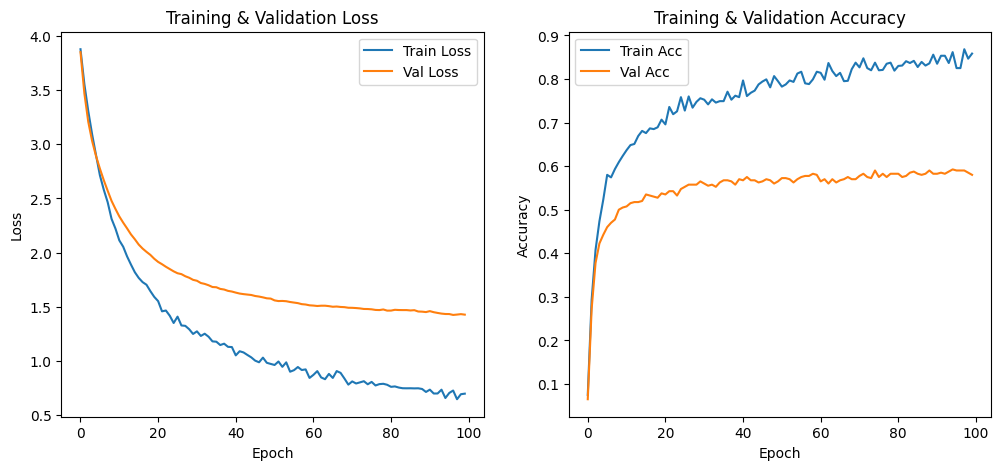

In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Training function ---
def train_epoch(loader, lambda_guide=0.5):
    model.train()
    total_loss, correct = 0, 0

    for x, y in tqdm(loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        # DiffRes
        ret = diffres(x)
        features = ret["feature"]               # [B, 3, T_new, F]
        features = features.permute(0, 1, 3, 2) # [B, 3, F, T_new]
        features = F.interpolate(features, size=(224, 224), mode='bilinear', align_corners=False)

        out = model(features)
        cls_loss = criterion(out, y)
        guide_loss = ret["guide_loss"].mean()
        loss = cls_loss + lambda_guide * guide_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()

    acc = correct / len(loader.dataset)
    return total_loss / len(loader), acc

# --- Validation function ---
def eval_epoch(loader):
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            # DiffRes forward sama seperti training
            ret = diffres(x)
            features = ret["feature"].permute(0,1,3,2)
            features = F.interpolate(features, size=(224,224), mode='bilinear', align_corners=False)

            out = model(features)
            loss = criterion(out, y)

            total_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()

    acc = correct / len(loader.dataset)
    return total_loss / len(loader), acc

# --- Training loop ---
train_losses, val_losses = [], []
train_accs, val_accs = [], []

epochs = 100
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(train_loader)
    val_loss, val_acc = eval_epoch(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f" Train  Loss={train_loss:.4f} Acc={train_acc:.4f}")
    print(f" Val    Loss={val_loss:.4f} Acc={val_acc:.4f}")

# --- Test evaluation ---
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        ret = diffres(x)
        features = ret["feature"].permute(0,1,3,2)
        features = F.interpolate(features, size=(224,224), mode='bilinear', align_corners=False)

        out = model(features)
        preds = out.argmax(dim=1).cpu().numpy()
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds)

acc = accuracy_score(y_true, y_pred)
cls_report = classification_report(y_true, y_pred, digits=4)
cm = confusion_matrix(y_true, y_pred)

print("\n====== TEST RESULTS ======")
print(f"Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(cls_report)
print("\nConfusion Matrix:")
print(cm)

# --- Plot training curves ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()
